In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import rcParams

# 全局字体设置 (黑体 SimHei 为例)
rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


In [2]:
net_value = pd.read_csv('NetValue.csv')

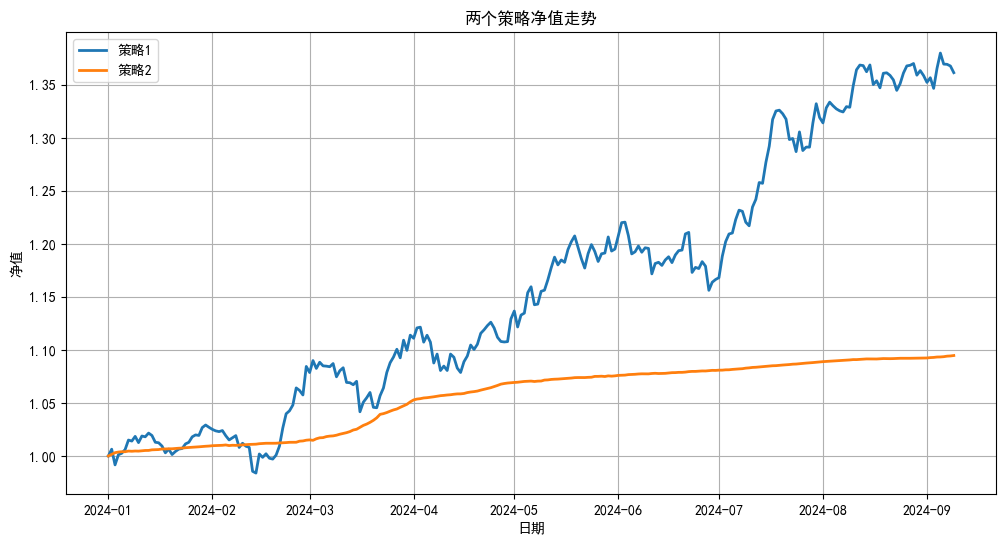

In [3]:
net_value['Date'] = pd.to_datetime(net_value['Date'], format='%Y%m%d')
net_value.set_index('Date', inplace=True)

# Normalize the net values to 1 at the beginning
net_value['NetValue1'] = net_value['NetValue1'] / net_value['NetValue1'].iloc[0]
net_value['NetValue2'] = net_value['NetValue2'] / net_value['NetValue2'].iloc[0]

# Calculate the daily returns for both strategies
net_value['Return1'] = net_value['NetValue1'].pct_change()
net_value['Return2'] = net_value['NetValue2'].pct_change()

# Plot the net values for both strategies
plt.figure(figsize=(12, 6))
plt.plot(net_value.index, net_value['NetValue1'], label='策略1', linewidth=2)
plt.plot(net_value.index, net_value['NetValue2'], label='策略2', linewidth=2)
plt.xlabel('日期')
plt.ylabel('净值')
plt.title('两个策略净值走势')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
net_value = net_value[['NetValue1','NetValue2']]

In [5]:
# 计算每日收益率
returns = net_value.pct_change().dropna()

# 定义统计函数
def calculate_metrics(returns, risk_free_rate=0.02, trading_days=365):
    metrics = {}
    
    # 年化收益
    annual_return = (1 + returns.mean()) ** trading_days - 1
    
    # 年化波动率
    annual_volatility = returns.std() * np.sqrt(trading_days)
    
    # 最大回撤
    cumulative_returns = (1 + returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # 夏普比率
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility
    
    # 克莱玛比率
    calmar_ratio = annual_return / abs(max_drawdown)
    
    # 索提诺比率
    downside_returns = returns[returns < 0]
    downside_std = downside_returns.std() * np.sqrt(trading_days)
    sortino_ratio = (annual_return - risk_free_rate) / downside_std
    
    # 汇总
    metrics['Annual Return'] = annual_return
    metrics['Annual Volatility'] = annual_volatility
    metrics['Max Drawdown'] = max_drawdown
    metrics['Sharpe Ratio'] = sharpe_ratio
    metrics['Calmar Ratio'] = calmar_ratio
    metrics['Sortino Ratio'] = sortino_ratio
    
    return metrics

# 对两个策略分别计算指标
metrics_netvalue1 = calculate_metrics(returns['NetValue1'])
metrics_netvalue2 = calculate_metrics(returns['NetValue2'])

# 创建表格
metrics_df = pd.DataFrame({
    'NetValue1': metrics_netvalue1,
    'NetValue2': metrics_netvalue2
})

# 转置表格使其更易读
metrics_df = metrics_df.T

In [6]:
metrics_df

,Annual Return,Annual Volatility,Max Drawdown,Sharpe Ratio,Calmar Ratio,Sortino Ratio
NetValue1,0.583460,0.159598,-0.052668,3.530503,11.078026,5.003855
NetValue2,0.140147,0.008835,-0.000584,13.599008,239.804016,41.582255


In [7]:
# 假设您的数据是 net_value，先计算每日收益率
returns = net_value.pct_change().dropna()

# 定义候选滚动窗口期
window_sizes = [5,10,15, 20,25, 30,35, 40,45, 50]

# 风险平价模型的优化函数
def risk_parity_weights(cov_matrix):
    n = len(cov_matrix)
    init_weights = np.ones(n) / n
    bounds = [(0, 1) for _ in range(n)]
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    
    # 风险贡献差异作为目标函数
    def risk_parity_obj(weights):
        portfolio_variance = weights.T @ cov_matrix @ weights
        marginal_risks = cov_matrix @ weights / portfolio_variance
        risk_contributions = weights * marginal_risks
        return np.sum((risk_contributions - risk_contributions.mean()) ** 2)

    result = minimize(risk_parity_obj, init_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    if result.success:
        return result.x
    else:
        return init_weights  # 如果优化失败，返回等权重

# 均值-方差模型的优化函数
def mean_variance_weights(mean_returns, cov_matrix, target_return):
    n = len(mean_returns)
    init_weights = np.ones(n) / n
    bounds = [(0, 1) for _ in range(n)]  # Each weight is between 0 and 1

    # Constraints
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights sum to 1
        {'type': 'ineq', 'fun': lambda x: np.dot(x, mean_returns) - target_return}  # Target return constraint
    ]

    # Objective function: minimize portfolio variance
    def portfolio_variance(weights):
        return weights.T @ cov_matrix @ weights

    result = minimize(portfolio_variance, init_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        return result.x
    else:
        return init_weights  # Return equal weights if optimization fails
# 存储结果
results = []

# 滚动验证
for window_size in window_sizes:
    for model_name, weight_func in [('Risk Parity', risk_parity_weights), ('Mean-Variance', mean_variance_weights)]:
        model_returns = []
        
        # 滚动窗口
        for start in range(0, len(returns) - window_size, window_size):
            if start < window_size:  # First window, use equal weights
                weights = np.array([0.5, 0.5])
            else:  # Use calculated weights for subsequent windows
                window_data = returns.iloc[start-window_size:start]
                mean_returns = window_data.mean()
                target_return = mean_returns.mean()
                cov_matrix = window_data.cov()
                
                if model_name == 'Risk Parity':
                    weights = weight_func(cov_matrix)
                else:
                    weights = weight_func(mean_returns, cov_matrix,target_return)
            
            # 应用权重到下一个窗口
            next_window_returns = returns.iloc[start:start+window_size]
            portfolio_returns = next_window_returns @ weights
            model_returns.extend(portfolio_returns)
        
        # 计算模型指标
        metrics = calculate_metrics(pd.Series(model_returns))
        metrics['Window Size'] = window_size
        metrics['Model'] = model_name
        results.append(metrics)

# Equal Weight Strategy (50/50 for NetValue1 and NetValue2)
equal_weight_returns = returns @ np.array([0.5, 0.5])  # Fixed 50/50 weights
equal_weight_metrics = calculate_metrics(equal_weight_returns)
equal_weight_metrics['Window Size'] = 'N/A'
equal_weight_metrics['Model'] = 'Equal Weight (50/50)'
results.append(equal_weight_metrics)

# 转为 DataFrame
results_df = pd.DataFrame(results)

In [8]:
metrics_df['Model'] = ['Strategy 1', 'Strategy 2']  # 添加 Model 列
metrics_df['Window Size'] = 'N/A'  # 添加 Window Size 列，标记为 'N/A'

# 合并 metrics_df 和 results_df
combined_results_df = pd.concat([results_df, metrics_df], ignore_index=True)
combined_results_df.sort_values(by = 'Model')

,Annual Return,Annual Volatility,Max Drawdown,Sharpe Ratio,Calmar Ratio,Sortino Ratio,Window Size,Model
20,0.343693,0.079968,-0.024492,4.047807,14.032598,5.822819,N/A,Equal Weight (50/50)
11,0.367545,0.080519,-0.024492,4.316295,15.006435,6.071462,30,Mean-Variance
1,0.352005,0.080194,-0.024492,4.140044,14.371972,5.938655,5,Mean-Variance
3,0.352005,0.080194,-0.024492,4.140044,14.371972,5.938655,10,Mean-Variance
19,0.352005,0.080194,-0.024492,4.140044,14.371972,5.938655,50,Mean-Variance
5,0.367545,0.080519,-0.024492,4.316295,15.006435,6.071462,15,Mean-Variance
7,0.367545,0.080519,-0.024492,4.316295,15.006435,6.071462,20,Mean-Variance
17,0.393545,0.081778,-0.024492,4.567770,16.067975,6.399579,45,Mean-Variance
9,0.352005,0.080194,-0.024492,4.140044,14.371972,5.938655,25,Mean-Variance
15,0.367545,0.080519,-0.024492,4.316295,15.006435,6.071462,40,Mean-Variance


In [9]:
# Extract the latest 30 days of returns
latest_30_days = returns.iloc[-30:]  # Use the last 30 rows from the returns DataFrame

# Calculate the covariance matrix for the latest 30 days
cov_matrix = latest_30_days.cov()

# Get the Risk Parity weights
rp_weights = risk_parity_weights(cov_matrix)

# Display the weights
print("Risk Parity Weights for the latest 30 days:")
print(rp_weights)

Risk Parity Weights for the latest 30 days:
[0.02017295 0.97982705]


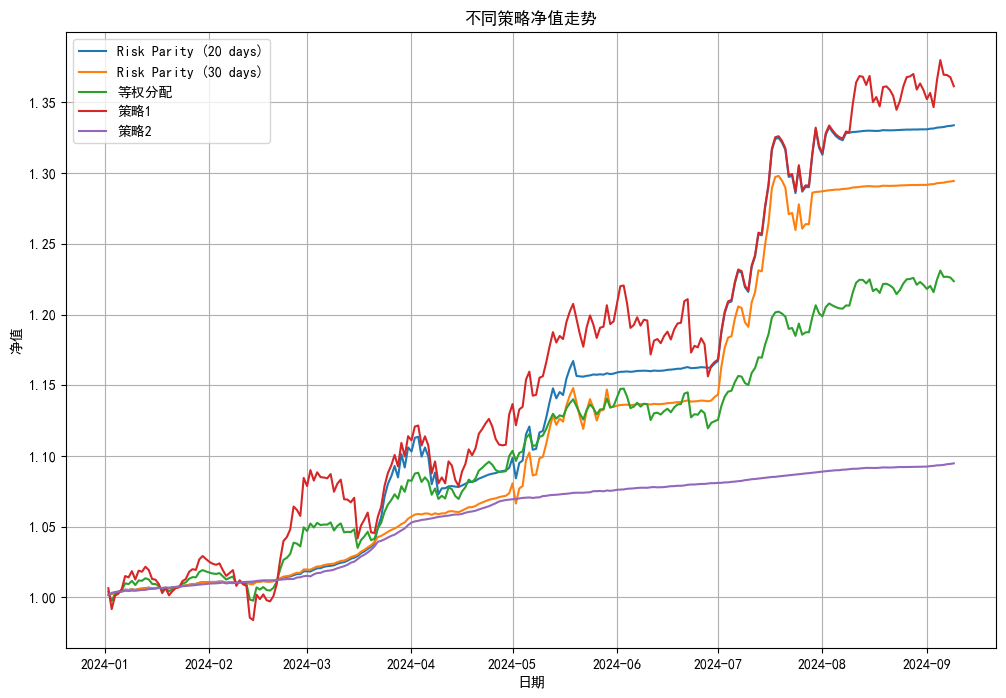

In [10]:

# Function to calculate net value from portfolio returns
def calculate_net_value(portfolio_returns):
    return (1 + portfolio_returns).cumprod()

# Initialize dictionary to store net values for each strategy
net_values = {}

# Define strategies for NV sequence plotting
strategies_to_plot = [
    {'name': 'Risk Parity (20 days)', 'window_size': 20, 'weight_func': risk_parity_weights},
    {'name': 'Risk Parity (30 days)', 'window_size': 30, 'weight_func': risk_parity_weights},
]

# Compute Net Value for each strategy
for strategy in strategies_to_plot:
    strategy_name = strategy['name']
    window_size = strategy['window_size']
    weight_func = strategy['weight_func']
    strategy_returns = []
    weights = np.array([0.5, 0.5])  # Start with equal weights for the first window

    # Rolling computation
    for start in range(0, len(returns), window_size):
        if start + window_size <= len(returns):
            # Use the previous window to calculate weights
            window_data = returns.iloc[start:start + window_size]
            prev_data = returns.iloc[start - window_size:start] if start >= window_size else returns.iloc[:start + window_size]

            mean_returns = prev_data.mean()
            cov_matrix = prev_data.cov()
            weights = weight_func(cov_matrix)

            # Apply weights to the current window
            portfolio_returns = (window_data @ weights).dropna()
            strategy_returns.extend(portfolio_returns)
        else:
            # For the final period, use the last available full window's weights
            final_window_data = returns.iloc[start:]
            portfolio_returns = (final_window_data @ weights).dropna()
            strategy_returns.extend(portfolio_returns)

    # Calculate net value
    strategy_returns = pd.Series(strategy_returns, index=returns.index[:len(strategy_returns)])
    net_values[strategy_name] = calculate_net_value(strategy_returns)

# Add Equal Weight and Benchmarks
net_values['等权分配'] = calculate_net_value(returns @ np.array([0.5, 0.5]))
net_values['策略1'] = calculate_net_value(returns['NetValue1'])
net_values['策略2'] = calculate_net_value(returns['NetValue2'])

# Plot Net Value sequences
plt.figure(figsize=(12, 8))

for strategy_name, nv_sequence in net_values.items():
    plt.plot(nv_sequence.index, nv_sequence, label=strategy_name)

plt.title('不同策略净值走势')
plt.xlabel('日期')
plt.ylabel('净值')
plt.legend()
plt.grid()
plt.show()